**EDA - AirBnB pricing project**

In [274]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
# load data
path_data = '../Data/'

#list of all data names
city_data = ['jc_listings','jc_calendar','jc_locale','jc_reviews',
             'nyc_listings','nyc_calendar','nyc_locale','nyc_reviews',
             'rio_listings','rio_calendar','rio_locale','rio_reviews']
                   
dfs = {}

# loop to load all the data with respective name
for city in city_data:
    dfs[city] = pd.read_pickle(path_data+city+'.pkl')    
    
for key,val in dfs.items():
    exec(key + '=val')

In [3]:
# delete dfs dictionary to free memory
del dfs

*Sasonality Analisis*

In [4]:
#inspecting the data frames
jc_calendar.info(),nyc_calendar.info(),rio_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739519 entries, 0 to 935899
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      739519 non-null  int64         
 1   date            739519 non-null  datetime64[ns]
 2   available       739519 non-null  object        
 3   price           739348 non-null  float64       
 4   adjusted_price  739348 non-null  float64       
 5   minimum_nights  739146 non-null  float64       
 6   maximum_nights  739146 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 45.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8255562 entries, 0 to 14551461
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4

(None, None, None)

In [5]:
# Only keep selected listing id 
jc_calendar = jc_calendar[jc_calendar['listing_id'].isin(jc_listings['id'])]
nyc_calendar = nyc_calendar[nyc_calendar['listing_id'].isin(nyc_listings['id'])]
rio_calendar = rio_calendar[rio_calendar['listing_id'].isin(rio_listings['id'])]

The date and price are objects, will transform them in datetime and float object types

In [6]:
# changing date column to pandas datetime object
jc_calendar['date'] = pd.to_datetime(jc_calendar['date']) 
nyc_calendar['date'] = pd.to_datetime(nyc_calendar['date'])
rio_calendar['date'] = pd.to_datetime(rio_calendar['date'])

In [7]:
# changing price column to a float object
jc_calendar['price'] = jc_calendar.price.replace({'\$': '',',':''},regex=True).astype(float)
nyc_calendar['price'] = nyc_calendar.price.replace({'\$': '',',':''},regex=True).astype(float)
rio_calendar['price'] = rio_calendar.price.replace({'\$': '',',':''},regex=True).astype(float)

In [8]:
# changing adjusted price to a float object
jc_calendar['adjusted_price'] = jc_calendar.adjusted_price.replace({'\$': '',',':''},regex=True).astype(float)
nyc_calendar['adjusted_price'] = nyc_calendar.adjusted_price.replace({'\$': '',',':''},regex=True).astype(float)
rio_calendar['adjusted_price'] = rio_calendar.adjusted_price.replace({'\$': '',',':''},regex=True).astype(float)

In [9]:
# saving changes calendar dataset for later use

jc_calendar.to_pickle(path_data+'jc_calendar.pkl')
nyc_calendar.to_pickle(path_data+'nyc_calendar.pkl')
rio_calendar.to_pickle(path_data+'rio_calendar.pkl')

Visual analysis of aggregated time series of listing prices

Prices distribution isn't symetric; therefore, we will examine the mean and median.

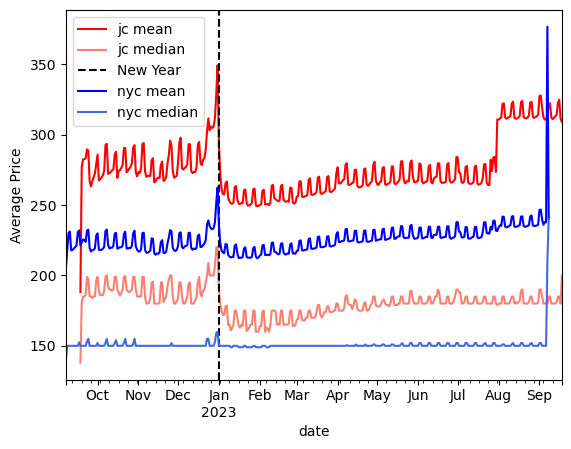

In [10]:
jc_calendar.groupby('date')['price'].mean().plot(color = 'r')
jc_calendar.groupby('date')['price'].median().plot(color = 'salmon')
plt.axvline(x=['2023-01-01'], color='black', linestyle='--')
plt.ylabel("Average Price")

nyc_calendar.groupby('date')['price'].mean().plot(color = 'b')
nyc_calendar.groupby('date')['price'].median().plot(color = 'royalblue')
plt.legend(['jc mean','jc median','New Year','nyc mean','nyc median']);

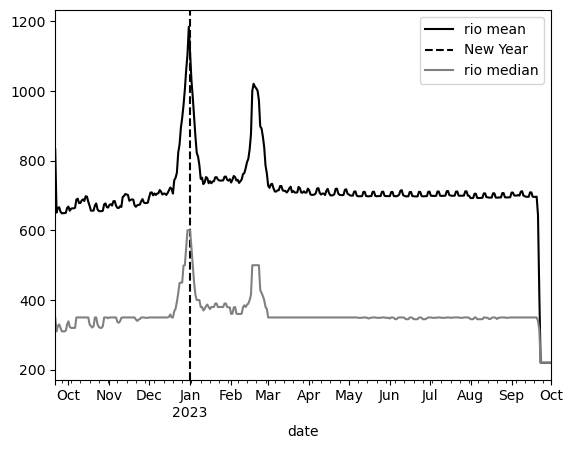

In [11]:
rio_calendar.groupby('date')['price'].mean().plot(color='black')
plt.axvline(x=['2023-01-01'], color='black', linestyle='--')
rio_calendar.groupby('date')['price'].median().plot(color='grey')
plt.legend(['rio mean','New Year','rio median']);

All three datasets show sesonability. Analysis of mean price show that NJ seems to have a high demand season and a low demand season. Both NY and NJ had significant increase in christmans and new year. Rio the end of year price effect lasts longer and there is a long lasting Carnaval effect also. Median price profile for NJ and Rio data have similar profile than median price, but less volatility and day of the week different. In contrast NY median price data show very little sesonability.

*Check the effect of weekday on prices*

In [12]:
#create a columns with weekday
jc_calendar['weekday'] = jc_calendar['date'].dt.dayofweek
nyc_calendar['weekday'] = nyc_calendar['date'].dt.dayofweek
rio_calendar['weekday'] = rio_calendar['date'].dt.dayofweek

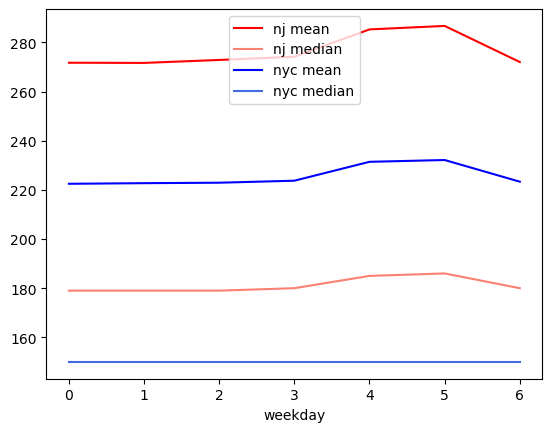

In [13]:
jc_calendar.groupby('weekday')['price'].mean().plot(color = 'r')
jc_calendar.groupby('weekday')['price'].median().plot(color = 'salmon')
nyc_calendar.groupby('weekday')['price'].mean().plot(color = 'b')
nyc_calendar.groupby('weekday')['price'].median().plot(color = 'royalblue')
plt.legend(['nj mean','nj median','nyc mean','nyc median']);
# Monday = 0, Sunday = 6

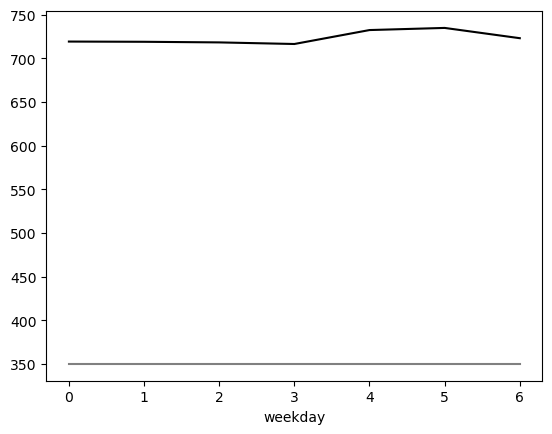

In [97]:
rio_calendar.groupby('weekday')['price'].mean().plot(color = 'black')
rio_calendar.groupby('weekday')['price'].median().plot(color = 'grey');

Nj show clear price differentiation based on the day of the week. Both NY and Rio show price differentiation of average price but no differentiation of median price.

Overal, the analysis sugests that seaonability is correlated to price level. We stratify the data into price segments and check the level of seasonability at each level.

In [69]:
# Selecting price range for stratification
jc_listings.groupby(['bedrooms'])['price'].describe()

,count,mean,std,min,25%,50%,75%,max
bedrooms,,,,,,,,
1.0,1151.0,214.549088,212.947021,20.0,86.00,151.0,300.00,3300.0
2.0,454.0,294.370044,257.177908,41.0,130.00,200.0,388.25,2000.0
3.0,177.0,433.717514,579.000539,64.0,180.00,269.0,398.00,4929.0
4.0,56.0,942.625000,902.160146,100.0,264.00,448.0,1502.25,2850.0
5.0,13.0,685.461538,666.245527,170.0,253.00,442.0,885.00,2671.0
6.0,3.0,748.666667,652.441824,325.0,373.00,421.0,960.50,1500.0
7.0,2.0,650.500000,492.853426,302.0,476.25,650.5,824.75,999.0
8.0,1.0,467.000000,NaN,467.0,467.00,467.0,467.00,467.0
9.0,1.0,1000.000000,NaN,1000.0,1000.00,1000.0,1000.00,1000.0


In [18]:
print(jc_calendar.head(1).T, jc_listings.head(1).T)

                                  0
listing_id                  9329465
date            2022-09-18 00:00:00
available                         f
price                         190.0
adjusted_price                190.0
minimum_nights                  3.0
maximum_nights               1125.0
weekday                           6                                                                                               0
id                                                                                        14175
description                                   3 bed, 1 bath, sleeps 6<br />Three bedroom apa...
host_since                                                                           2009-11-19
host_response_time                                                               within an hour
host_response_rate                                                                         100%
host_acceptance_rate                                                                       100%
host

In [22]:
# Merger of selected columns 
cal = jc_calendar[['listing_id','date','price','weekday']]
listing = jc_listings[['id','bedrooms']]
nj_join = pd.merge(cal,listing, left_on='listing_id', right_on='id')

In [30]:
nj_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739519 entries, 0 to 739518
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  739519 non-null  int64         
 1   date        739519 non-null  datetime64[ns]
 2   price       739348 non-null  float64       
 3   weekday     739519 non-null  int64         
 4   id          739519 non-null  int64         
 5   bedrooms    677469 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 39.5 MB


In [56]:
# stratification of NJ listing by bedrooms and price
# 1 bedroom 
nj_strat_1 = nj_join.query('bedrooms == 1')
# 2 bedrooms 
nj_strat_2 = nj_join.query('bedrooms == 2')
# 3 bedrooms
nj_strat_3 =  nj_join.query('bedrooms == 3')

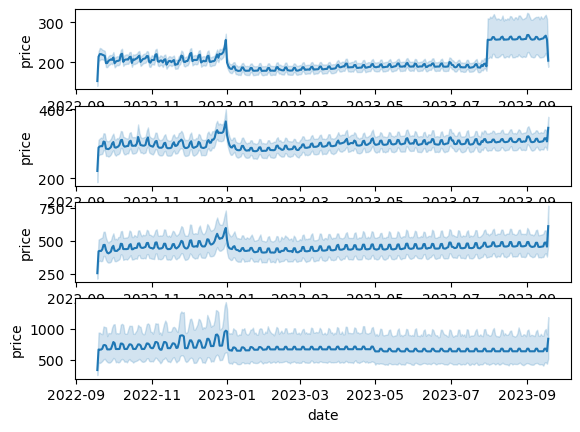

In [92]:
fig, axes = plt.subplots(4,1)
sns.lineplot(x = 'date', y = 'price', data = nj_strat_1, ax =axes[0])
sns.lineplot(x = 'date', y = 'price', data = nj_strat_2, ax =axes[1])
sns.lineplot(x = 'date', y = 'price', data = nj_strat_3, ax =axes[2])
sns.lineplot(x='date', y= 'price', data = nj_join.query('bedrooms > 4'), ax =axes[3]);

Sazonability isn't dependent on number of bedrooms. The most variance happen on begining of year (or begining of time series) listings. Similarly listings are sensitive to the day of the week and end of year holiday. 

In [87]:
arr = [[nj_strat_1.query('date == "2022-12-01"').price.mean(),
      nj_strat_1.query('date == "2022-12-31"').price.mean()],
       [nj_strat_2.query('date == "2022-12-01"').price.mean(),
      nj_strat_2.query('date == "2022-12-31"').price.mean()],
       [nj_strat_3.query('date == "2022-12-01"').price.mean(),
      nj_strat_3.query('date == "2022-12-31"').price.mean()]
      ]
df = pd.DataFrame(arr)
nj_pct_change = df.pct_change(axis=1)[1]

In [88]:
print(df, '\n',nj_pct_change)

            0           1
0  209.627826  256.174783
1  291.801762  364.947137
2  462.966102  599.265537 
 0    0.222046
1    0.250668
2    0.294405
Name: 1, dtype: float64


The end of the year premium is higher than 20% and premium increases with the number of bedrooms. 

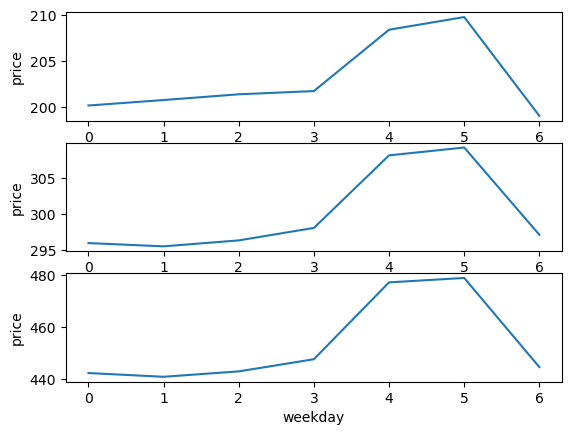

In [97]:
fig, axes = plt.subplots(3,1)
sns.lineplot(nj_strat_1.groupby('weekday')['price'].mean(), ax =axes[0])
sns.lineplot(nj_strat_2.groupby('weekday')['price'].mean(), ax =axes[1])
sns.lineplot(nj_strat_3.groupby('weekday')['price'].mean(), ax =axes[2]);

In [102]:
df = pd.concat([nj_strat_1.groupby('weekday')['price'].mean(),
                  nj_strat_2.groupby('weekday')['price'].mean(),
                  nj_strat_3.groupby('weekday')['price'].mean()], axis=1)

print(df)

              price       price       price
weekday                                    
0        200.129537  295.919059  442.272199
1        200.729026  295.462725  440.836701
2        201.354434  296.291300  442.910365
3        201.706755  298.033802  447.576597
4        208.399157  308.161894  477.099196
5        209.781467  309.257201  478.788353
6        198.998521  297.074992  444.549387


In [106]:
nj_day_pct_change = (df.max() - df.min())/df.min()
print(nj_day_pct_change)

price    0.054186
price    0.046688
price    0.086090
dtype: float64


Friday and Saturnday are the most expensive days, however the premium is relativelly small aroung 5% for 1 and 2 bedrooms and 9% for 3 bedrroms.

In [107]:
cal = nyc_calendar[['listing_id','date','price','weekday']]
listing = nyc_listings[['id','bedrooms']]
nyc_join = pd.merge(cal,listing, left_on='listing_id', right_on='id')

In [108]:
nyc_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8255562 entries, 0 to 8255561
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   listing_id  int64         
 1   date        datetime64[ns]
 2   price       float64       
 3   weekday     int64         
 4   id          int64         
 5   bedrooms    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 440.9 MB


In [113]:
nyc_listings.groupby(['bedrooms'])['price'].describe()

,count,mean,std,min,25%,50%,75%,max
bedrooms,,,,,,,,
1.0,14410.0,167.030951,317.985245,21.0,76.00,115.0,188.00,10000.0
2.0,4036.0,279.810951,271.157878,10.0,150.00,201.0,305.25,4143.0
3.0,1594.0,375.380803,390.624732,28.0,195.00,272.5,400.00,5000.0
4.0,387.0,645.620155,701.980550,30.0,291.50,412.0,731.00,8614.0
5.0,92.0,939.130435,1179.478794,65.0,425.00,619.5,973.00,10000.0
6.0,30.0,1088.233333,917.258535,200.0,551.00,741.0,1260.75,3557.0
7.0,10.0,1012.800000,683.670616,545.0,643.00,739.0,1072.50,2800.0
8.0,7.0,1107.428571,524.106496,745.0,824.50,879.0,1118.00,2243.0
9.0,2.0,821.500000,111.015765,743.0,782.25,821.5,860.75,900.0


In [109]:
# stratification of NYC listing by bedrooms and price
# 1 bedroom 
nyc_strat_1 = nyc_join.query('bedrooms == 1')
# 2 bedroom 
nyc_strat_2 = nyc_join.query('bedrooms == 2')
# 3 bedroom 
nyc_strat_3 = nyc_join.query('bedrooms == 3')

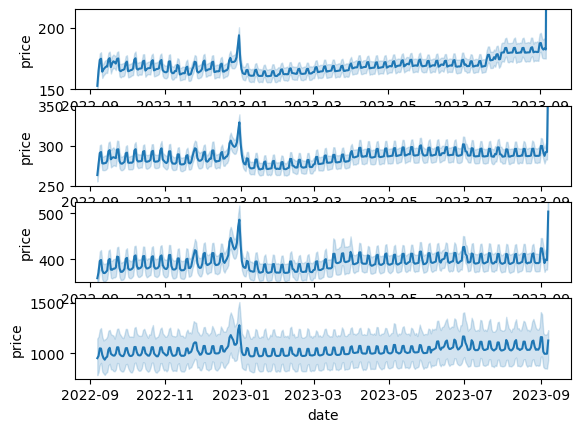

In [129]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,sharey=False)
sns.lineplot(x = 'date', y = 'price', data = nyc_strat_1, ax =ax1)
ax1.set_ylim(150, 215)
sns.lineplot(x = 'date', y = 'price', data = nyc_strat_2, ax =ax2)
ax2.set_ylim(250, 350)
sns.lineplot(x = 'date', y = 'price', data = nyc_strat_3, ax =ax3)
ax3.set_ylim(350, 525)
sns.lineplot(x = 'date', y = 'price', data = nyc_join.query('bedrooms > 4'), ax =ax4);

Similarly to Jersey City, sazonability isn't dependent on number of bedrooms. Listings are sensitive to the day of the week and end of year holiday.

In [153]:
arr = [[nyc_strat_1.query('date == "2022-12-01"').price.mean(),
      nyc_strat_1.query('date == "2022-12-31"').price.mean()],
       [nyc_strat_2.query('date == "2022-12-01"').price.mean(),
      nyc_strat_2.query('date == "2022-12-31"').price.mean()],
       [nyc_strat_3.query('date == "2022-12-01"').price.mean(),
      nyc_strat_3.query('date == "2022-12-31"').price.mean()]
      ]
df = pd.DataFrame(arr)
nyc_pct_change = df.pct_change(axis=1)[1]

In [154]:
print(nyc_pct_change)

0    0.163604
1    0.160109
2    0.244866
Name: 1, dtype: float64


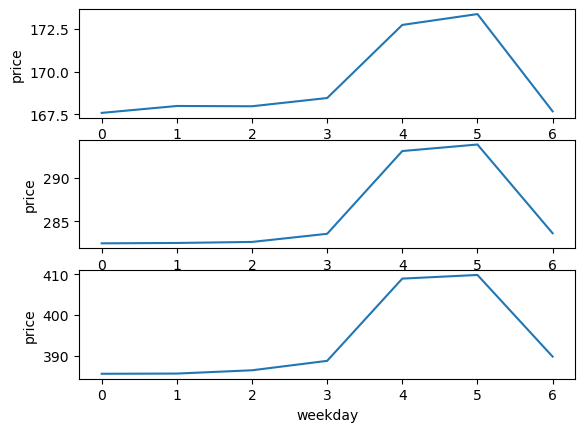

In [130]:
fig, axes = plt.subplots(3,1)
sns.lineplot(nyc_strat_1.groupby('weekday')['price'].mean(), ax =axes[0])
sns.lineplot(nyc_strat_2.groupby('weekday')['price'].mean(), ax =axes[1])
sns.lineplot(nyc_strat_3.groupby('weekday')['price'].mean(), ax =axes[2]);

Friday and Saturnday are the most expensive days, however the premium is relativelly small aroung 4% for 1 and 2 bedrooms and 6% for 3 bedrroms.

In [131]:
df = pd.concat([nyc_strat_1.groupby('weekday')['price'].mean(),
                  nyc_strat_2.groupby('weekday')['price'].mean(),
                  nyc_strat_3.groupby('weekday')['price'].mean()], axis=1)

print(df)

              price       price       price
weekday                                    
0        167.584664  282.446934  385.536531
1        167.987826  282.489336  385.589760
2        167.972158  282.608633  386.395636
3        168.453689  283.549967  388.711503
4        172.725897  293.127506  408.922474
5        173.360265  293.882667  409.818635
6        167.677510  283.613693  389.759109


In [132]:
nyc_day_pct_change = (df.max() - df.min())/df.min()
print(nyc_day_pct_change)

price    0.034464
price    0.040488
price    0.062983
dtype: float64


In [133]:
cal = rio_calendar[['listing_id','date','price','weekday']]
listing = rio_listings[['id','bedrooms']]
rio_join = pd.merge(cal,listing, left_on='listing_id', right_on='id')

In [134]:
rio_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8485425 entries, 0 to 8485424
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   listing_id  int64         
 1   date        datetime64[ns]
 2   price       float64       
 3   weekday     int64         
 4   id          int64         
 5   bedrooms    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 453.2 MB


In [135]:
# Selecting price range for stratification
rio_listings.groupby(['bedrooms'])['price'].describe()

,count,mean,std,min,25%,50%,75%,max
bedrooms,,,,,,,,
1.0,12232.0,353.237083,632.269349,40.0,150.0,230.0,357.00,20000.0
2.0,6102.0,699.843002,1004.766320,48.0,290.0,450.0,800.00,22600.0
3.0,2727.0,1129.994499,1439.948081,60.0,451.5,705.0,1229.50,25000.0
4.0,663.0,2400.972851,2810.831221,70.0,800.0,1500.0,3000.00,25000.0
5.0,202.0,3534.079208,3535.050473,80.0,1135.5,2098.0,4500.00,20106.0
6.0,107.0,3602.682243,3012.429326,70.0,1200.0,2500.0,5419.00,11765.0
7.0,34.0,3609.029412,3991.243882,163.0,1164.0,2200.5,4710.25,15343.0
8.0,13.0,5065.000000,4079.808125,906.0,2329.0,4000.0,7357.00,16000.0
9.0,11.0,5655.363636,3412.055752,70.0,3363.0,6250.0,7506.00,11100.0


In [136]:
# stratification of NYC listing by bedrooms and price
# 1 bedroom 
rio_strat_1 = rio_join.query('bedrooms == 1')
# 2 bedroom 
rio_strat_2 = rio_join.query('bedrooms == 2')
# 3 bedroom 
rio_strat_3 = rio_join.query('bedrooms == 3')

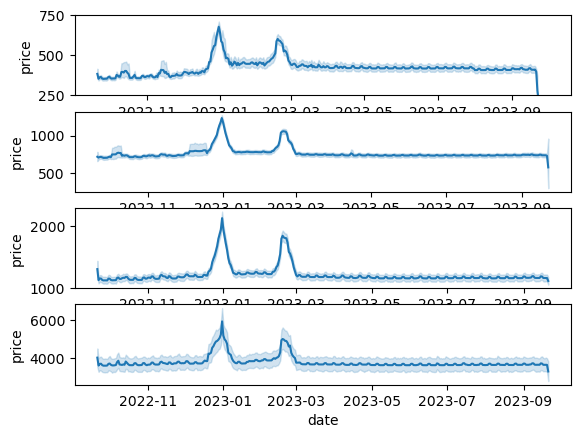

In [141]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,sharey=False)
sns.lineplot(x = 'date', y = 'price', data = rio_strat_1, ax =ax1)
ax1.set_ylim(250,750)
sns.lineplot(x = 'date', y = 'price', data = rio_strat_2, ax =ax2)
sns.lineplot(x = 'date', y = 'price', data = rio_strat_3, ax =ax3)
sns.lineplot(x = 'date', y = 'price', data = rio_join.query('bedrooms > 4'), ax =ax4);

Rio, sazonality is marked by bimodal distribution. Besides end of year holidays, Carnaval affects listing prices significantly. The figure shows the existance on weekdays sazonality also. In addition, the price premium for end of year abd carnaval is significantly higher than Jersey City and New York. Rio listing end of year premium is over 60% and 30% for carnaval.

In [174]:
arr = [[rio_strat_1.query('date == "2022-12-01"').price.mean(),
      rio_strat_1.query('date == "2022-12-31"').price.mean()],
       [rio_strat_2.query('date == "2022-12-01"').price.mean(),
      rio_strat_2.query('date == "2022-12-31"').price.mean()],
       [rio_strat_3.query('date == "2022-12-01"').price.mean(),
      rio_strat_3.query('date == "2022-12-31"').price.mean()],
       [rio_strat_1.query('date == "2023-02-01"').price.mean(),
      rio_strat_1.query('date == "2023-02-18"').price.mean()],
       [rio_strat_2.query('date == "2023-02-01"').price.mean(),
      rio_strat_2.query('date == "2023-02-18"').price.mean()],
       [rio_strat_3.query('date == "2023-02-01"').price.mean(),
      rio_strat_3.query('date == "2023-02-18"').price.mean()]
      ]
df = pd.DataFrame(arr)
rio_pct_change = df.pct_change(axis=1)[1]

In [175]:
print(rio_pct_change)

0    0.762932
1    0.632019
2    0.777436
3    0.376349
4    0.360687
5    0.498302
Name: 1, dtype: float64


In [192]:
rio_end_year = rio_pct_change[0:3]
rio_carnaval = rio_pct_change[3:].reset_index(drop=True)


In [193]:
rio_carnaval

0    0.376349
1    0.360687
2    0.498302
Name: 1, dtype: float64

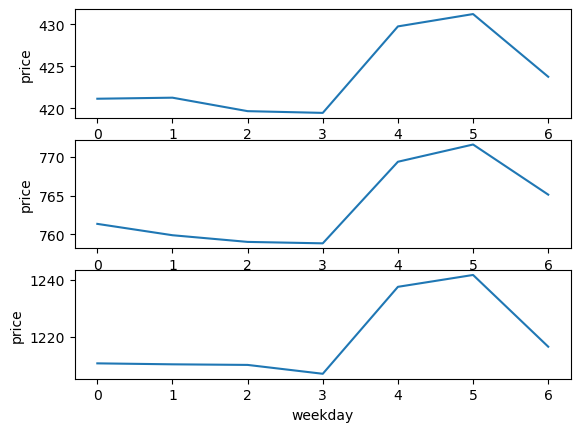

In [157]:
fig, axes = plt.subplots(3,1)
sns.lineplot(rio_strat_1.groupby('weekday')['price'].mean(), ax =axes[0])
sns.lineplot(rio_strat_2.groupby('weekday')['price'].mean(), ax =axes[1])
sns.lineplot(rio_strat_3.groupby('weekday')['price'].mean(), ax =axes[2]);

Friday and Saturday have a small premium, rio weekday sazonality is the lowest among the cities studied.

In [158]:
df = pd.concat([rio_strat_1.groupby('weekday')['price'].mean(),
                rio_strat_2.groupby('weekday')['price'].mean(),
                rio_strat_3.groupby('weekday')['price'].mean()], axis=1)

print(df)

              price       price        price
weekday                                     
0        421.122624  761.357796  1210.567417
1        421.247989  759.900086  1210.229986
2        419.639629  759.042743  1210.019523
3        419.432899  758.859173  1206.900311
4        429.757389  769.336022  1237.501692
5        431.230116  771.549880  1241.676892
6        423.743190  765.111644  1216.429685


In [159]:
rio_day_pct_change = (df.max() - df.min())/df.min()
print(rio_day_pct_change)

price    0.028127
price    0.016723
price    0.028815
dtype: float64


Saving sazonality data

In [205]:
data = {'Jersey City': nj_pct_change, 
        'NYC':nyc_pct_change,
        'Rio':rio_end_year,
        'Rio_carnaval':rio_carnaval}
sazonal = pd.concat(data, axis =1, )

In [206]:
sazonal['bedrooms'] = [1,2,3]
sazonal.set_index(keys='bedrooms', inplace=True)
print(sazonal)

          Jersey City       NYC       Rio  Rio_carnaval
bedrooms                                               
1            0.222046  0.163604  0.762932      0.376349
2            0.250668  0.160109  0.632019      0.360687
3            0.294405  0.244866  0.777436      0.498302


In [208]:
sazonal.to_pickle(path_data+'sazonal.pkl')

In [211]:
day_data = {'Jersey City': nj_day_pct_change,
           'NYC': nyc_day_pct_change,
           'Rio': rio_day_pct_change}
sazonal_day = pd.concat(day_data, axis=1)

In [212]:
print(sazonal_day)

       Jersey City       NYC       Rio
price     0.054186  0.034464  0.028127
price     0.046688  0.040488  0.016723
price     0.086090  0.062983  0.028815


In [213]:
sazonal_day.to_pickle(path_data+'sazonal_day.pkl')

Feature Engineering 

I will fit a PCA transformation and a corrlation heat map to select which features will be used in the pricing model

In [217]:
jc_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2028 entries, 0 to 2565
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2028 non-null   int64  
 1   description                                   1999 non-null   object 
 2   host_since                                    2028 non-null   object 
 3   host_response_time                            1959 non-null   object 
 4   host_response_rate                            1959 non-null   object 
 5   host_acceptance_rate                          1979 non-null   object 
 6   host_is_superhost                             2028 non-null   object 
 7   host_listings_count                           2028 non-null   int64  
 8   host_total_listings_count                     2028 non-null   int64  
 9   host_verifications                            2028 non-null   o

In [218]:
jc_listings.columns

Index(['id', 'description', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'rev

In [238]:
cols = ['id', 'host_since', 'host_is_superhost', 'host_identity_verified', 
        'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms',
        'beds', 'price', 'number_of_reviews', 'review_scores_rating',
        'review_scores_cleanliness', 'review_scores_location', 
        'review_scores_value', 'reviews_per_month']

In [239]:
jc_features = jc_listings[cols]
jc_features.head().T

,0,1,2,3,4
id,14175,23686,36703,40669,60164
host_since,2009-11-19,2010-03-15,2010-07-05,2010-07-20,2010-11-17
host_is_superhost,t,f,t,f,f
host_identity_verified,t,t,t,f,t
latitude,40.75729,40.72961,40.73271,40.73742,40.72012
longitude,-74.03782,-74.00308,-74.00367,-74.05255,-74.00397
room_type,Entire home/apt,Entire home/apt,Entire home/apt,Private room,Entire home/apt
accommodates,6,4,2,2,6
bedrooms,3.0,3.0,1.0,1.0,3.0
beds,3.0,3.0,2.0,1.0,3.0


In [240]:
jc_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2028 entries, 0 to 2565
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         2028 non-null   int64  
 1   host_since                 2028 non-null   object 
 2   host_is_superhost          2028 non-null   object 
 3   host_identity_verified     2028 non-null   object 
 4   latitude                   2028 non-null   float64
 5   longitude                  2028 non-null   float64
 6   room_type                  2028 non-null   object 
 7   accommodates               2028 non-null   int64  
 8   bedrooms                   1858 non-null   float64
 9   beds                       1973 non-null   float64
 10  price                      2028 non-null   float64
 11  number_of_reviews          2028 non-null   int64  
 12  review_scores_rating       1708 non-null   float64
 13  review_scores_cleanliness  1706 non-null   float

In [241]:
jc_features['host_is_superhost'] = jc_features['host_is_superhost'].map({'t':1,'f':0})
jc_features['host_identity_verified'] = jc_features['host_identity_verified'].map({'t':1,'f':0});

/var/folders/3d/rkb9lbfx5y11yrd72m9hzxzm0000gn/T/ipykernel_52566/3783596135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jc_features['host_is_superhost'] = jc_features['host_is_superhost'].map({'t':1,'f':0})
/var/folders/3d/rkb9lbfx5y11yrd72m9hzxzm0000gn/T/ipykernel_52566/3783596135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jc_features['host_identity_verified'] = jc_features['host_identity_verified'].map({'t':1,'f':0});


In [247]:
jc_features.host_since = pd.to_datetime(jc_features.host_since)

/var/folders/3d/rkb9lbfx5y11yrd72m9hzxzm0000gn/T/ipykernel_52566/1280476357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jc_features.host_since = pd.to_datetime(jc_features.host_since)


In [248]:
jc_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2028 entries, 0 to 2565
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2028 non-null   int64         
 1   host_since                 2028 non-null   datetime64[ns]
 2   host_is_superhost          2028 non-null   int64         
 3   host_identity_verified     2028 non-null   int64         
 4   latitude                   2028 non-null   float64       
 5   longitude                  2028 non-null   float64       
 6   room_type                  2028 non-null   object        
 7   accommodates               2028 non-null   int64         
 8   bedrooms                   1858 non-null   float64       
 9   beds                       1973 non-null   float64       
 10  price                      2028 non-null   float64       
 11  number_of_reviews          2028 non-null   int64         
 12  review

In [251]:
jc_features.room_type.unique()

array(['Entire home/apt', 'Private room'], dtype=object)

In [259]:
scaled_cols = jc_features.drop(['id','host_since','room_type'], axis =1).columns
scaled = scale(jc_features.drop(['id','host_since','room_type'], axis =1))

In [260]:
jc_features_scaled = pd.DataFrame(scaled, columns = scaled_cols)

In [261]:
jc_features_scaled.head()

,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_location,review_scores_value,reviews_per_month
0,1.641338,0.340772,1.379786,0.004893,0.815469,1.575650,0.629062,-0.518584,-0.423378,-0.387947,-1.433832,0.674170,-0.540991,-0.399434
1,-0.609259,0.340772,0.049635,1.246395,0.052483,1.575650,0.629062,0.910202,0.227242,-0.471345,-0.902732,0.627021,-0.088680,-0.331652
2,1.641338,0.340772,0.198604,1.225311,-0.710502,-0.637168,-0.060460,-0.228273,1.417738,0.466877,0.478127,0.627021,0.299016,-0.198696
3,-0.609259,-2.934514,0.424941,-0.521513,-0.710502,-0.637168,-0.749982,-0.433199,-0.395692,0.654522,0.690567,0.674170,0.794404,-0.430717
4,-0.609259,0.340772,-0.406403,1.214590,0.815469,1.575650,0.629062,0.665430,0.974763,-0.638140,-1.093928,-0.504536,-0.885608,-0.237800


In [270]:
jc_features_scaled.dropna(inplace=True)
jc_features_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1531 entries, 0 to 2002
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_is_superhost          1531 non-null   float64
 1   host_identity_verified     1531 non-null   float64
 2   latitude                   1531 non-null   float64
 3   longitude                  1531 non-null   float64
 4   accommodates               1531 non-null   float64
 5   bedrooms                   1531 non-null   float64
 6   beds                       1531 non-null   float64
 7   price                      1531 non-null   float64
 8   number_of_reviews          1531 non-null   float64
 9   review_scores_rating       1531 non-null   float64
 10  review_scores_cleanliness  1531 non-null   float64
 11  review_scores_location     1531 non-null   float64
 12  review_scores_value        1531 non-null   float64
 13  reviews_per_month          1531 non-null   float

In [271]:
jc_pca = PCA().fit(jc_features_scaled)

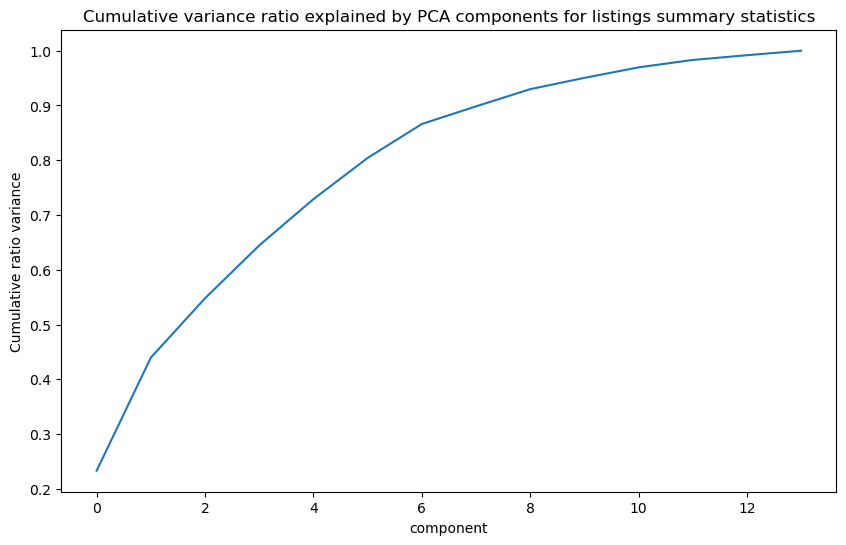

In [272]:
plt.subplots(figsize=(10, 6))
plt.plot(jc_pca.explained_variance_ratio_.cumsum())
plt.xlabel('component')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for listings summary statistics');

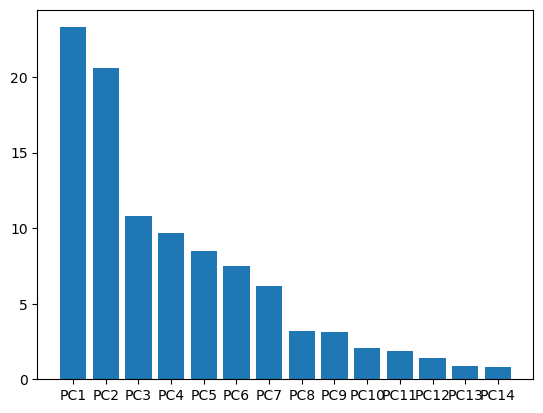

In [275]:
per_var = np.round(jc_pca.explained_variance_ratio_*100, decimals = 1)
labels = ['PC'+str(x) for x in range(1,len(per_var)+1)]

plt.bar(x = range(1,len(per_var)+1), height = per_var, tick_label = labels)
plt.show()

In [276]:
pca_data = jc_pca.transform(jc_features_scaled)
pca_df = pd.DataFrame(pca_data, columns = labels)

In [278]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,1.014972,1.151769,-0.183720,0.453590,-0.520114,-0.946369,-1.939893,-1.165628,1.064574,-0.537485,0.257404,-0.909630,-0.159771,-0.193100
1,0.673620,1.070710,-1.604947,0.848932,0.402163,-0.073886,0.303670,-0.672690,-0.281060,-0.671235,-0.252403,-1.053802,0.273029,0.469353
2,-1.665706,-0.599984,0.228032,1.388348,0.377244,-0.264851,-1.211660,-0.521864,-0.821249,0.054934,-0.164190,0.162003,-0.094102,0.472805
3,-1.490319,-0.812073,0.643698,-0.947167,-0.972476,-2.074352,2.007471,0.152465,0.136222,0.041919,0.277253,-0.099584,0.057367,-0.040225
4,1.786762,1.200300,-0.910411,1.156157,0.678093,0.186163,0.266116,-0.551672,-0.980269,-0.308091,-0.701680,-0.719190,-0.158738,-0.064560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,-0.257702,-0.988641,0.307532,-1.519525,-0.009429,0.783951,0.311974,1.481098,-0.386460,-0.014621,-1.018373,0.355270,-0.032105,-0.312210
1527,-1.021075,0.786856,-0.975174,-0.292882,-0.671991,0.378721,0.330339,0.364690,0.418001,-0.048293,0.101677,-0.293867,0.085998,-0.287155
1528,-0.012561,0.113556,-0.398092,-0.831246,-0.582670,0.484700,0.237825,-0.335279,0.315673,0.378744,0.380684,-0.472083,1.794194,-0.107688
1529,-0.783428,0.788306,2.013272,-2.928924,0.806927,-1.011238,2.599216,-0.345464,0.172032,0.107507,0.536347,-0.350041,0.055674,-0.443480


In [296]:
for i in range(0,6):
    pca_features = pd.DataFrame({labels[i]: jc_pca.components_[i],
                                 'Variable Names':list(scaled_cols)})
    print(pca_features)

         PC1             Variable Names
0  -0.197117          host_is_superhost
1   0.036942     host_identity_verified
2   0.017174                   latitude
3  -0.151369                  longitude
4   0.148217               accommodates
5   0.153686                   bedrooms
6   0.155604                       beds
7  -0.003701                      price
8  -0.069395          number_of_reviews
9  -0.455772       review_scores_rating
10 -0.463007  review_scores_cleanliness
11 -0.446911     review_scores_location
12 -0.487462        review_scores_value
13 -0.049905          reviews_per_month
         PC2             Variable Names
0   0.026742          host_is_superhost
1  -0.048932     host_identity_verified
2   0.037944                   latitude
3  -0.050822                  longitude
4   0.540387               accommodates
5   0.520165                   bedrooms
6   0.548200                       beds
7   0.234940                      price
8   0.058274          number_of_reviews


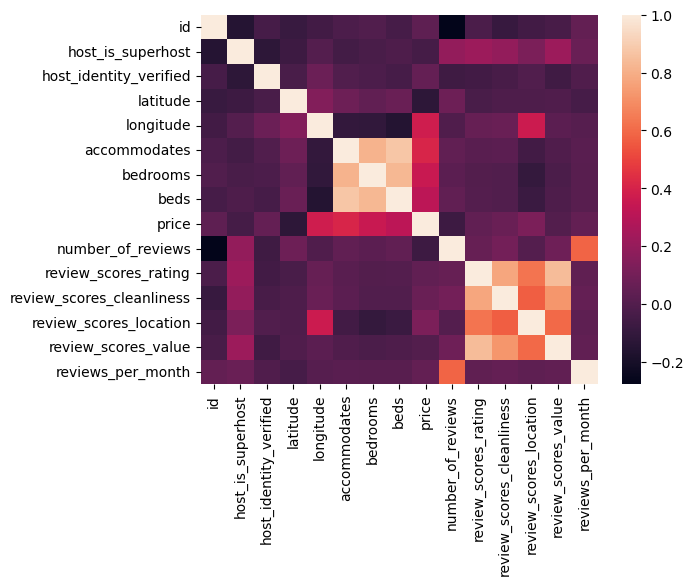

In [286]:
sns.heatmap(jc_features.corr());

In [287]:
nyc_features = nyc_listings[cols]

In [289]:
nyc_features['host_is_superhost'] = nyc_features['host_is_superhost'].map({'t':1,'f':0})
nyc_features['host_identity_verified'] = nyc_features['host_identity_verified'].map({'t':1,'f':0})

/var/folders/3d/rkb9lbfx5y11yrd72m9hzxzm0000gn/T/ipykernel_52566/454348638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_features['host_is_superhost'] = nyc_features['host_is_superhost'].map({'t':1,'f':0})
/var/folders/3d/rkb9lbfx5y11yrd72m9hzxzm0000gn/T/ipykernel_52566/454348638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_features['host_identity_verified'] = nyc_features['host_identity_verified'].map({'t':1,'f':0})


In [290]:
nyc_features.host_since = pd.to_datetime(nyc_features.host_since)

/var/folders/3d/rkb9lbfx5y11yrd72m9hzxzm0000gn/T/ipykernel_52566/345097157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_features.host_since = pd.to_datetime(nyc_features.host_since)


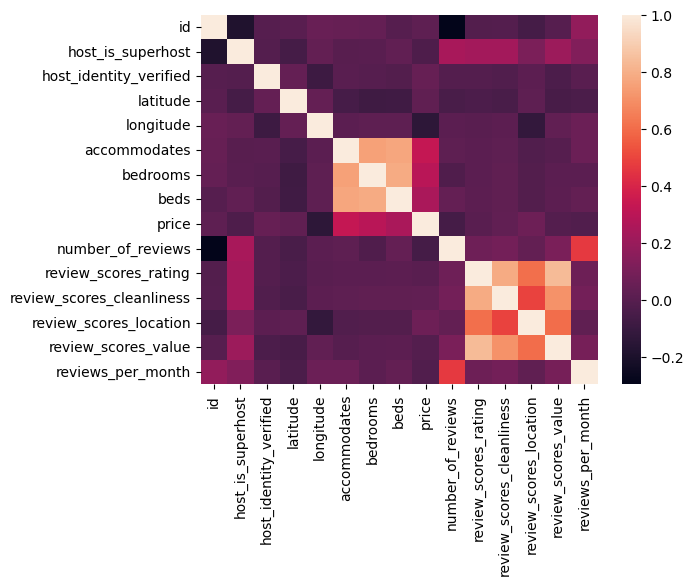

In [291]:
sns.heatmap(nyc_features.corr());

In [292]:
rio_features = rio_listings[cols]

In [293]:
rio_features['host_is_superhost'] = rio_features['host_is_superhost'].map({'t':1,'f':0})
rio_features['host_identity_verified'] = rio_features['host_identity_verified'].map({'t':1,'f':0})

/var/folders/3d/rkb9lbfx5y11yrd72m9hzxzm0000gn/T/ipykernel_52566/552760642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rio_features['host_is_superhost'] = rio_features['host_is_superhost'].map({'t':1,'f':0})
/var/folders/3d/rkb9lbfx5y11yrd72m9hzxzm0000gn/T/ipykernel_52566/552760642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rio_features['host_identity_verified'] = rio_features['host_identity_verified'].map({'t':1,'f':0})


In [294]:
rio_features.host_since = pd.to_datetime(rio_features.host_since)

/var/folders/3d/rkb9lbfx5y11yrd72m9hzxzm0000gn/T/ipykernel_52566/294954377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rio_features.host_since = pd.to_datetime(rio_features.host_since)


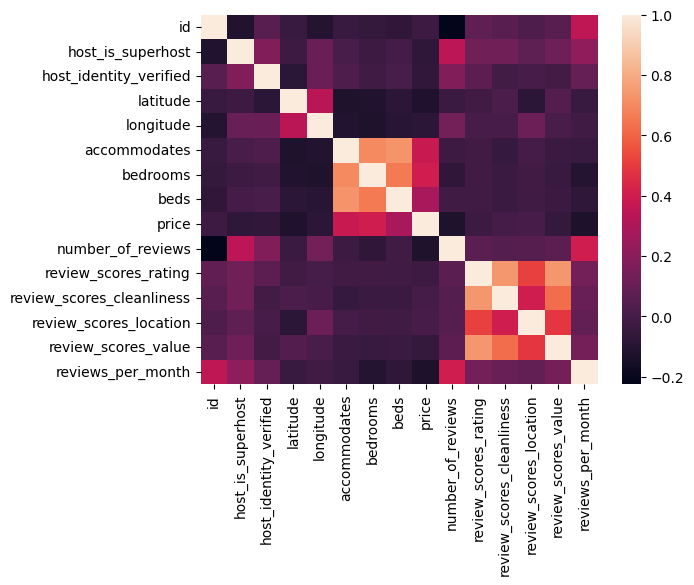

In [295]:
sns.heatmap(rio_features.corr());

The dimention reduction analysis through PCA was not conclusive, because each pricipal component explanation power were retalive small. It takes 6 PCs to explain around 90% of the variation.

The correlation heat map was able to help in feature engeneering. The price was positively correlated with accommodates (number of people the list is able to accommodates), (number of ) bedrroms and (number of) beds. reviews on sores rating, cleaningess, location and value was positive for most cities. Jersey city and Newyork identity verifies of host was also positive, but this might be cause by the number of rooms rental instead of the hole apartment.

Number of review or review per month doesn't seem to have a positive corrlation with price.

While accommodates, bedrooms and beds are all positive correlated with price they are highly correlated among themself therefore we will use only accommodates feature for modeling to avoid cross-correlation among the explanatory variable.

latitude and longitude correlation was mixed but we will use neghboorhod information for out modeling.

We chose the following features for our modeling

In [298]:
features = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'room_type',
            'accommodates', 'review_scores_rating', 'review_scores_cleanliness',
            'review_scores_location', 'review_scores_value']

In [299]:
print(features)

['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'room_type', 'accommodates', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value']
